In [1]:
import math
def quicksort(arr, compare):
    if len(arr) <= 1:
        return arr
    pivot = arr[len(arr) // 2]
    left = [x for x in arr if compare(x, pivot) == 1]
    middle = [x for x in arr if compare(x, pivot) == 2]
    right = [x for x in arr if compare(x, pivot) == 0]
    return quicksort(left, compare) + middle + quicksort(right, compare)

In [2]:
def inP(c):
    for i in range(len(c.processors)):
        print("(", c.processors[i].typed, c.processors[i].idd, ")", end = " ")
    print()

In [3]:
network = 20*1024*1024

class processor:
    def __init__(self, cu, cost):
        self.cu = cu
        self.cost = cost

numberOfProcessors = 9
listProcessors = [
    processor(1, 0.12),
    processor(1.5, 0.195),
    processor(2, 0.28),
    processor(2.5, 0.375),
    processor(3, 0.48),
    processor(3.5, 0.595),
    processor(4, 0.72),
    processor(4.5, 0.855),
    processor(5, 1)
]

class VM:
    def __init__(self, typed, idd):
        self.typed = typed
        self.idd = idd

In [4]:
import random
import numpy as np

In [5]:
import xml.etree.ElementTree as ET
import numpy as np
import re

def extractNumberFromString(string):
    numbers = re.findall(r'\d+', string)
    if numbers:
        return int(numbers[0])  

class task:
    def __init__(self, sources, destinations, dataSize):
        self.sources = sources
        self.destinations = destinations
        self.dataSize = dataSize

class workFlow:
    def __init__(self, filePath, deadline):
        self.numberOfTasks = extractNumberFromString(filePath)
        self.tasks = [task([], [], 0)] * self.numberOfTasks
        self.DAG = self.getDAGFromXml(filePath)
        self.deadline = deadline
        degree = self.getDegree()
        self.inDegree = degree[0]
        self.zeroInDegree = degree[1]
        self.subDeadline = [-1] * self.numberOfTasks
        self.rank = [-1] * self.numberOfTasks
        self.calSubDeadline()
       
    def getDAGFromXml(self, filePath):
        tree = ET.parse(filePath)
        root = tree.getroot()

        # dx là 1 dict như sau: dx[name][0] là mảng chứa id của các jobs nhận dữ liệu đầu vào có tên là name
        ######################: dx[name][1] là giá trị id của job xuất ra dữ liệu có tên là name
        dx = {}
        namespace = {'dax': 'http://pegasus.isi.edu/schema/DAX'}

        DAG = [[0 for _ in range(self.numberOfTasks)] for _ in range(self.numberOfTasks)]
        jobs = {}
        inData = [[]] * self.numberOfTasks
        outData = [[]] * self.numberOfTasks

        tasks = []
        for i in range(self.numberOfTasks):
            tasks.append(task([], [], 0))
        self.numberOfTasks = 0
        for job in root.findall('.//dax:job', namespace):
            job_id = extractNumberFromString(job.attrib['id'])
            self.numberOfTasks = max(self.numberOfTasks, job_id)
            uses = job.findall('.uses', namespace)
            inputs = []
            outputs = []
            dataSize = 0

            for use in job.findall('.//dax:uses', namespace):
                file = use.attrib['file']
                link = use.attrib['link']
                data = int(use.attrib['size'])
                if data < 0:
                    data = 0 - data
                if file not in dx:
                    dx[file] = [[], -1, data]
                if link == 'input':
                    dx[file][0].append(job_id)
                elif link == 'output':
                    dx[file][1] = job_id

            #inData[job_id] = inputs
            #outData[job_id] = outputs

            #!__________________________________________________
            tasks[job_id].dataSize = float(job.attrib['runtime'])
        self.numberOfTasks += 1
        for dependencies in root.findall('.//dax:child', namespace):
            childId = extractNumberFromString(dependencies.attrib['ref'])
            for parents in dependencies.findall('.//dax:parent', namespace):
                parentId = extractNumberFromString(parents.attrib['ref'])
                tasks[childId].sources.append(parentId)
                tasks[parentId].destinations.append(childId)

        for key in dx:
            for i in range(len(dx[key][0])):
                if dx[key][1] == -1:
                    continue
                DAG[dx[key][1]][dx[key][0][i]] = dx[key][2] / network
        for i in range(self.numberOfTasks):
            self.tasks[i] = tasks[i]
        return DAG

    def calRank(self, task):
        self.rank[task] =  self.tasks[task].dataSize / listProcessors[8].cu 
        maxx = 0
        for j in range(len(self.tasks[task].destinations)):
            child = self.tasks[task].destinations[j]
            if self.rank[child] == -1:
                self.calRank(child)
            maxx = max(maxx, self.rank[child] + self.DAG[task][child] / network)
        self.rank[task] += maxx
        
    def calSubDeadline(self):
        outDegree = [0] * self.numberOfTasks
        for i in range(0, self.numberOfTasks):
            outDegree[i] += len(self.tasks[i].destinations)
        zeroOutDegree = []
        for i in range(0, self.numberOfTasks):
            if outDegree[i] == 0:
                zeroOutDegree.append(i)     
                
        inDegree_copy = self.inDegree[:]
        zeroInDegree_copy = self.zeroInDegree[:]
        maxSpeed = listProcessors[8].cu
        
        while(len(zeroOutDegree) > 0):
            task = zeroOutDegree[0]
            zeroOutDegree.pop(0)
            if self.rank[task] == -1:
                self.calRank(task)
            for j in range(len(self.tasks[task].sources)):
                adj = self.tasks[task].sources[j]
                outDegree[adj] -= 1
                if outDegree[adj] == 0:
                    zeroOutDegree.append(adj)
        
        rankEntry = 0
        for i in range(len(self.zeroInDegree)):
            tt = self.zeroInDegree[i]
            rankEntry = max(rankEntry, self.rank[tt])
        for i in range(self.numberOfTasks):
            self.subDeadline[i] = (self.deadline / rankEntry) * (rankEntry - self.rank[i] + (self.tasks[i].dataSize / maxSpeed))
        
    def getDegree(self):
        inDegree = [0] * self.numberOfTasks
        zeroInDegree = []
        for i in range(0, self.numberOfTasks):
            inDegree[i] += len(self.tasks[i].sources)
        for i in range(0, self.numberOfTasks):
            if inDegree[i] == 0:
                zeroInDegree.append(i)
        return (inDegree, zeroInDegree)

In [6]:
def isBetter(a, b):
    
    if a.completionTime == b.completionTime and a.cost == b.cost:
        return 2
    if a.completionTime <= workflow.deadline and b.completionTime <= workflow.deadline:
        return a.cost < b.cost
    if a.completionTime <= workflow.deadline and b.completionTime > workflow.deadline:
        return 1
    if a.completionTime > workflow.deadline and b.completionTime > workflow.deadline:
        return a.completionTime < b.completionTime
    if a.completionTime > workflow.deadline and b.completionTime <= workflow.deadline:
        return 0

In [7]:
import math

def diff(a, b):
    return not ((a.typed == b.typed) and (a.idd == b.idd))

class Chromosome:
    def __init__(self, processors, tasks):
        self.processors = processors
        self.tasks = tasks
        self.completionTime = 0
        self.FTofTasks = [0.0] * numberOfTasks
        self.cost = 0.0
        self.isHillClimbing = False
        #self.cal_fitness()

    @staticmethod
    def crossover(chromosome1, chromosome2, crossover_rate):

        numTasks = len(chromosome1.tasks)
        Child1 = Chromosome([VM(0, 0)] * numTasks, [-1] * numTasks)
        Child2 = Chromosome([VM(0, 0)] * numTasks, [-1] * numTasks)

        if random.random() > crossover_rate:
            return None

        t = random.randint(0, 1)
        if 1:
            #get position to crossover
            pos = random.randint(1, numTasks)
            dxC1 = [False] * (numTasks + 1)
            dxC2 = [False] * (numTasks + 1)
            #take left part from parents
            for i in range(pos):
                Child1.tasks[i] = copy.deepcopy(chromosome1.tasks[i])
                Child1.processors[i] = copy.deepcopy(chromosome1.processors[i])
                dxC1[chromosome1.tasks[i]] = True
                Child2.tasks[i] = copy.deepcopy(chromosome2.tasks[i])
                Child2.processors[i] = copy.deepcopy(chromosome2.processors[i])
                dxC2[chromosome2.tasks[i]] = True

            #take right part from parents
            ps = pos
            for i in range(numTasks):
                if dxC1[chromosome2.tasks[i]] == False:
                    Child1.processors[ps] = copy.deepcopy(chromosome2.processors[i])
                    Child1.tasks[ps] = copy.deepcopy(chromosome2.tasks[i])
                    dxC1[chromosome2.tasks[i]] = True
                    ps += 1
            ps = pos
            for i in range(numTasks):
                if dxC2[chromosome1.tasks[i]] == False:
                    Child2.processors[ps] = copy.deepcopy(chromosome1.processors[i])
                    Child2.tasks[ps] = copy.deepcopy(chromosome1.tasks[i])
                    dxC2[chromosome1.tasks[i]] = True
                    ps += 1

            return Child1, Child2
        '''else:
            crossover_point = random.randint(1, len(chromosome1.processors) - 1)
            
            head1 = copy.deepcopy(chromosome1.processors[:crossover_point])
            tail1 = copy.deepcopy(chromosome1.processors[crossover_point:])
            head2 = copy.deepcopy(chromosome2.processors[:crossover_point])
            tail2 = copy.deepcopy(chromosome2.processors[crossover_point:])
            
            # Tạo hai con mới
            Child1.processors = head1 + tail2
            Child2.processors = head2 + tail1
            
            Child1.tasks = copy.deepcopy(chromosome1.tasks)
            Child2.tasks = copy.deepcopy(chromosome2.tasks)
            
            return Child1, Child2'''

    def mutate(self, mutation_rate):
        rand = random.random()
        if rand < mutation_rate:
            mutated_processors = self.processors[:]  # Create a copy of distributing

            mutate_position = random.randint(0, len(mutated_processors) - 1)
            mutated_processors[mutate_position] = VM(random.randint(0, numberOfProcessors - 1), random.randint(0, numberOfTasks - 1))
            return Chromosome(mutated_processors, self.tasks)
        return self

    def self_improve(self):
        dx = {}
        mutated_processors = self.processors[:]  # Create a copy of distributing

        pool = []
        for i in range(len(self.processors)):
            typed = self.processors[i].typed
            idd = self.processors[i].idd
            if (typed, idd) not in dx:
                dx[(typed, idd)] = True
                pool.append((typed, idd))

        mutate_position = random.randint(0, len(mutated_processors) - 1)
        pos = random.randint(0, len(pool) - 1)
        mutated_processors[mutate_position] = VM(pool[pos][0], pool[pos][1])
        return Chromosome(mutated_processors, self.tasks)

    def cal_fitness(self):
        FTofTasks = [0] * numberOfTasks
        processor = [0] * numberOfTasks
        FT = np.zeros((numberOfProcessors, numberOfTasks))
        endLeaseTime = np.zeros((numberOfProcessors, numberOfTasks))
        startLeaseTime = array = np.full((numberOfProcessors, numberOfTasks), 1e9)
        dx = {}
        pool = []
        completionTime = 0.0
        cost = 0.0
        for i in range(len(self.tasks)):
            processor[self.tasks[i]] = self.processors[i]

        for i in range(len(self.tasks)):
            task = self.tasks[i]
            prc = self.processors[i].typed
            idd = self.processors[i].idd

            if ((prc, idd) not in dx):
                pool.append((prc, idd))
                dx[(prc, idd)] = True


            DAT_processor = FT[prc][idd]
            maxcost = 0.0
            for j in range(len(workflow.tasks[task].sources)):
                parent = workflow.tasks[task].sources[j]
                costTt = FTofTasks[parent] + ((DAG[parent][task]) if diff(processor[task], processor[parent]) else 0.0)
                DAT_processor = max(DAT_processor, costTt)
                maxcost = max(maxcost, costTt)
            FTofTasks[task] = DAT_processor + computationTime[task][prc]
            FT[prc][idd] = FTofTasks[task]
            self.FTofTasks[task] = FTofTasks[task]
            completionTime = max(completionTime, FTofTasks[task])

            endLeaseTime[prc][idd] = max(endLeaseTime[prc][idd], FTofTasks[task])
            for j in range(len(workflow.tasks[task].destinations)):
                child = workflow.tasks[task].destinations[j]
                costTt = FTofTasks[task] + ((DAG[task][child]) if diff(processor[task], processor[child]) else 0.0)
                endLeaseTime[prc][idd] = max(endLeaseTime[prc][idd], costTt)
                FT[prc][idd] = max(FT[prc][idd], costTt)

            startLeaseTime[prc][idd] = min(startLeaseTime[prc][idd], DAT_processor - maxcost)

        for i in range(len(pool)):
            cost += (math.ceil((endLeaseTime[pool[i][0]][pool[i][1]] - startLeaseTime[pool[i][0]][pool[i][1]]) / 3600)) * listProcessors[pool[i][0]].cost

        self.cost = cost
        self.completionTime = completionTime

In [8]:
import copy
import numpy as np

def improveHeuristic(chromosome):
    cTest = copy.deepcopy(chromosome)
    poolVm = []
    dx = [[False for _ in range(numberOfTasks)] for _ in range(numberOfProcessors)]      
    taskOfVm = np.empty((numberOfProcessors, numberOfTasks), dtype=object)
    for i in range(numberOfProcessors):
        for j in range(numberOfTasks):
            taskOfVm[i, j] = []

    for i in range(len(chromosome.processors)):
        Vm = chromosome.processors[i]
        if dx[Vm.typed][Vm.idd] == False:
            poolVm.append(Vm)
            dx[Vm.typed][Vm.idd] = True
        taskOfVm[Vm.typed][Vm.idd].append(i)
    
    for i in range(len(poolVm)):
        vm = poolVm[i]
        
    for i in range(len(poolVm)):
        vm1 = poolVm[i]
        tt = vm1.typed + 1
        xuly = []
        for j in range(len(taskOfVm[vm1.typed][vm1.idd])):
            xuly.append(taskOfVm[vm1.typed][vm1.idd][j])

        lastTask = chromosome.tasks[xuly[len(xuly) - 1]]
        while (chromosome.FTofTasks[lastTask] > workflow.subDeadline[lastTask] and tt < numberOfProcessors):
            '''if tt == vm1.typed:
                tt += 1
                continue'''
            for j in range(len(xuly)):
                taskt = xuly[j]
                chromosome.processors[taskt].typed = tt
            chromosome.cal_fitness()
            if isBetter(chromosome, cTest) == 1:
                cTest = chromosome
            tt += 1
    return cTest

In [9]:
def tournamentSelection(tournament):
    winner = Chromosome([], [])
    winner.completionTime = 1e8
    winner.cost = 1e8
    for i in range(len(tournament)):
        if isBetter(tournament[i], winner) == 1:
            winner = tournament[i]
    return winner

In [10]:
def chooseProcessor(task):
    return random.randint(0, numberOfProcessors - 1)

def createRandomChromosome(inDegree, zeroInDegree, typedd):
    inDegree_copy = inDegree[:]
    zeroInDegree_copy = zeroInDegree[:]
    maxNumOfVm = [0] * numberOfProcessors

    chromosome = Chromosome([0] * numberOfTasks, [0] * numberOfTasks)
    i = 0
    while(len(zeroInDegree_copy) > 0):
        index_task = random.randint(0, len(zeroInDegree_copy) - 1)
        task = zeroInDegree_copy[index_task]
        processor = chooseProcessor(task)
        chromosome.tasks[i] = task
        chromosome.processors[i] = VM(processor, 0)
        maxNumOfVm[processor] += 1
        zeroInDegree_copy.pop(index_task)
        for j in range(len(workflow.tasks[task].destinations)):
            adj = workflow.tasks[task].destinations[j]
            inDegree_copy[adj] -= 1
            if inDegree_copy[adj] == 0:
                zeroInDegree_copy.append(adj)
        i += 1
    if typedd == 1:
        for i in range(len(chromosome.tasks)):
            chromosome.processors[i].idd = random.randint(0, maxNumOfVm[chromosome.processors[i].typed] - 1)
    #multi thread
    chromosome.cal_fitness()
    return chromosome

def generateRandomPopulation(size, percentage, inDegree, zeroInDegree):
    randomPopulation = []

    size = math.ceil(size * percentage)
    randomType = 0
    for i in range(int(size * 0.75)):
        randomPopulation.append(createRandomChromosome(inDegree, zeroInDegree, 1))
    for i in range(int(size * 0.25)):
        randomPopulation.append(createRandomChromosome(inDegree, zeroInDegree, 0))
    return randomPopulation

In [11]:
def diff(a, b):
    return not ((a.typed == b.typed) and (a.idd == b.idd))

def createHeuristicChromosome(inDegree, zeroInDegree):
    inDegree_copy = inDegree[:]
    zeroInDegree_copy = zeroInDegree[:]
    chromosome = Chromosome([VM(0, 0)] * numberOfTasks, [0] * numberOfTasks)
    FT = np.zeros((numberOfProcessors, numberOfTasks))
    FT_thu = np.zeros(numberOfTasks)
    processor = [VM(0, 0)] * numberOfTasks
    FTofTasks = [0] * numberOfTasks
    i = 0

    while(len(zeroInDegree_copy) > 0):
        index_task = random.randint(0, len(zeroInDegree_copy) - 1)
        task = zeroInDegree_copy[index_task]

        find = False
        choosen = VM(0, 0)

        for typed in range(numberOfProcessors):
            if find:
                break
            idd = random.randint(0, numberOfTasks - 1)
            FT_thu[task] = 0
            DAT_processor = 0.0
            for k in range(len(workflow.tasks[task].sources)):
                parentTask = workflow.tasks[task].sources[k]
                DAT_processor = max(DAT_processor, FTofTasks[parentTask] + ((workflow.DAG[parentTask][task] / network) if diff(processor[task], processor[parentTask]) else 0.0))
            FT_thu[task] = max(DAT_processor, FT[typed][idd]) + computationTime[task][typed]
            if FT_thu[task] <= workflow.subDeadline[task]:
                find = True
                choosen = VM(typed, idd)
        if find == False:
            choosen = VM(random.randint(0, numberOfProcessors - 1), idd)


        chromosome.tasks[i] = task
        chromosome.processors[i] = choosen
        processor[task] = choosen
        FT[choosen.typed][choosen.idd] = FT_thu[task]
        FTofTasks[task] = FT_thu[task]

        zeroInDegree_copy.pop(index_task)
        for j in range(len(workflow.tasks[task].destinations)):
            adj = workflow.tasks[task].destinations[j]
            inDegree_copy[adj] -= 1
            if inDegree_copy[adj] == 0:
                zeroInDegree_copy.append(adj)
        i += 1

    #multi thread
    chromosome.cal_fitness()
    return chromosome

def generateHeuristicPopulation(size, percentage, inDegree, zeroInDegree):
    heuristicPopulation = []
    size = math.ceil(percentage * size)
    for i in range(size):
        chro = createHeuristicChromosome(inDegree, zeroInDegree)
        heuristicPopulation.append(chro)
    return heuristicPopulation

In [18]:
from concurrent.futures import ThreadPoolExecutor, as_completed

rand = 0
rouletteWheel = 1
tournament = 2

class GA:
    def __init__(self, workFlow, populationSize, perRandom, perHeuristic, perElitics, perHC, p_c, p_m):
        self.populationSize = populationSize
        self.worfFlow = workFlow
        self.p_c = p_c
        self.p_m = p_m
        self.maxGeneration = 0
        self.perRandom = perRandom
        self.perHeuristic = perHeuristic
        self.perElitics = perElitics
        self.perHC = perHC
        self.bestGene = 0

        self.population = generateRandomPopulation(populationSize, perRandom, workFlow.inDegree, workFlow.zeroInDegree) + generateHeuristicPopulation(populationSize, perHeuristic, workFlow.inDegree, workFlow.zeroInDegree)
        self.population = quicksort(self.population, isBetter)

    def recombination(self, lenNextGen, typee):
        ng = []
        if typee == rand:
            #used_parents = set()
            start = 0
            while (lenNextGen < self.populationSize):
                '''while True:
                    parents = tuple(random.sample(self.population, 2))
                    if parents not in used_parents:
                        used_parents.add(parents)
                        break'''
                parents = []
                parents.append(self.population[start])
                parents.append(self.population[random.randint(start + 1, len(self.population) - 1)])
                start += 1
                child = Chromosome.crossover(parents[0], parents[1], p_c)
                if child == None:
                    continue
                child0 = child[0].mutate(p_m)
                child1 = child[1].mutate(p_m)
                ng.append(child0)
                ng.append(child1)
                lenNextGen += 2

                child0.cal_fitness()
                child1.cal_fitness()

        if typee == rouletteWheel:
            wheel = copy.deepcopy(self.population)
            lenn = len(wheel)
            weights = [1 / (i + 1) for i in range(len(wheel))]
            total_weight = sum(weights)
            normalized_weights = [w / total_weight for w in weights]
        
            while lenNextGen < self.populationSize:
                if lenn - lenNextGen <= 1:
                    break
                selected_index1 = random.choices(range(len(wheel)), weights=normalized_weights, k=1)[0]
                element1 = wheel[selected_index1]

                selected_index2 = random.choices(range(len(wheel)), weights=normalized_weights, k=1)[0]
                element2 = wheel[selected_index2]

                child = Chromosome.crossover(element1, element2, p_c)
                if child is None:
                    continue

                lenNextGen += 2
                child0 = child[0].mutate(p_m)
                child1 = child[1].mutate(p_m)

                ng.append(child0)
                ng.append(child1)

                # Tính toán song song fitness cho các đứa con
                child0.cal_fitness()
                child1.cal_fitness()

        if typee == tournament:
            while lenNextGen < self.populationSize:
                parent1 = tournamentSelection(random.sample(self.population, 5))
                parent2 = tournamentSelection(random.sample(self.population, 5))

                child = Chromosome.crossover(parent1, parent2, p_c)
                if child is None:
                    continue

                lenNextGen += 2
                child0 = child[0].mutate(p_m)
                child1 = child[1].mutate(p_m)

                ng.append(child0)
                ng.append(child1)

                # Tính toán song song fitness cho các đứa con
                child0.cal_fitness()
                child1.cal_fitness()


        return ng

    def find_solution(self, typee):
        best = Chromosome([VM(0, 0)] * numberOfTasks, [0] * numberOfTasks)
        best.completionTime = 1e8
        best.cost = 1e8
        best.fitness = 1e8
        notImprove = 0
        hold = 0
        sizeElitics = int(self.populationSize * self.perElitics)
        #for gene in range(self.maxGeneration):
        gene = 0
        while gene >= 0:
            gene += 1
            #print(gene)
            nextGen = []
            for i in range(sizeElitics):
                nextGen.append(self.population[i])
            '''for i in range(len(self.population)):
                print(self.population[i].tasks)
                inP(self.population[i])
                print("_____________________________________")

            print(f'_________________________EndGene{gene}______________________________________________')'''
            childd = self.recombination(len(nextGen), typee)
            for i in range(len(childd)):
                nextGen.append(childd[i])
            nextGen = quicksort(nextGen, isBetter)
            ss = int(perHC * len(self.population))
            for _ in range(ss):
                selected_index = random.randint(0, len(nextGen) - 1)
                if nextGen[selected_index].isHillClimbing:
                    continue
                else:
                    if nextGen[selected_index].completionTime > workflow.deadline:
                        nextGen[selected_index].isHillClimbing = True
                        nextGen[selected_index] = improveHeuristic(nextGen[selected_index])

            for i in range(len(nextGen)):
                newC = nextGen[i].self_improve()
                newC.cal_fitness()
                if isBetter(newC, nextGen[i]):
                    nextGen[i] = newC

            nextGen = quicksort(nextGen, isBetter)
            if isBetter(nextGen[0], best) == 1:
                self.bestGene = gene
                best = nextGen[0]
                hold = 0
            else:
                hold += 1
            if (hold >=threshHold):
                break

            '''for i in range(len(nextGen)):
                inP(nextGen[i])
                print()
                print("_______________________________________")'''
            self.population = copy.deepcopy(nextGen)

        return best

In [19]:
import time
workflow = workFlow("D:\WorkFlowTest\dax/CyberShake_30.xml",  61.77777778)
computationTime = []
for i1 in range(workflow.numberOfTasks):
        computationTime.append([])
for i1 in range(workflow.numberOfTasks):
    for jj in range(numberOfProcessors):
        computationTime[i1].append(workflow.tasks[i1].dataSize / (listProcessors[jj].cu))
numberOfTasks = workflow.numberOfTasks
DAG = workflow.DAG
populationSize = 300
perRandom = 0.85
perHeuristic = 0.15
perElitics = 0.5
perHC = 0.6
p_c = 0.95
p_m = 0.02
maxGeneration = 0
threshHold = 75
res = 0
for i in range(5):
    start_time = time.time()
    ga = GA(workflow, populationSize, perRandom, perHeuristic, perElitics, perHC, p_c, p_m)
    sol = ga.find_solution(0)
    end_time = time.time()
    res += sol.cost
    print("++++++ ", sol.completionTime, sol.cost, end_time - start_time, ga.bestGene, " +++++++")
print(res / 5)

<>:2: SyntaxWarning: invalid escape sequence '\W'
<>:2: SyntaxWarning: invalid escape sequence '\W'
C:\Users\lminh\AppData\Local\Temp\ipykernel_16172\3124361273.py:2: SyntaxWarning: invalid escape sequence '\W'
  workflow = workFlow("D:\WorkFlowTest\dax/CyberShake_30.xml",  61.77777778)


++++++  61.42129798444112 3.8399999999999994 40.7511785030365 101  +++++++


C:\Users\lminh\AppData\Local\Temp\ipykernel_16172\3124361273.py:2: SyntaxWarning: invalid escape sequence '\W'
  workflow = workFlow("D:\WorkFlowTest\dax/CyberShake_30.xml",  61.77777778)


KeyboardInterrupt: 

In [13]:
#Algorithm compare

import numpy as np
import pandas as pd
from openpyxl import load_workbook
import os
import time
sizesWorkflow = ["30", "50", "100"]
nameWorkflow = ["/CyberShake", "/Epigenomics", "/LIGO", "/Montage"]
sourceDAX = "D:\WorkFlowTest\dax"
computationTime = []
cheapScheduleCost = np.array([
    [0.12, 0.12, 0.12],
    [0.6, 1.44, 13.56],
    [0.24, 0.48, 0.72],
    #[0.24, 0.48, 0.72],
    [0.12, 0.12, 0.12]
])
fastScheduleMakespan = np.array([[58.367999999999995, 60.58, 65.20400000000001],
    [1124.21, 1553.6480000000001, 5975.6500000000015],
    [267.03600000000006, 282.16, 266.552],
    #[267.03600000000006, 282.16, 266.552],
    [11.302, 14.152000000000001, 17.144000000000002]])
cheapScheduleMakespan = np.array([[760.5299999999999, 1524.5600000000004, 3215.7499999999995],
    [17720.15, 41401.780000000006, 403400.19999999995],
    [6617.0700000000015, 11761.949999999999, 21023.960000000003],
    #[6617.0700000000015, 11761.949999999999, 21023.960000000003],
    [227.74999999999997, 508.64000000000016, 1079.3400000000004]])
populationSize = 300
perRandom = 0.85
perHeuristic = 0.15
perElitics = 0.6
perHC = 0.6
p_c = 0.95
p_m = 0.02
threshHold = 75
result = pd.DataFrame(columns=['name', 'numOfTasks', 'iteration', 'factor', 'isSuccess', 'RunTime', 'Cost', 'bestGene'])

for ti in range(len(nameWorkflow)):
    graphType = nameWorkflow[ti]
    print(graphType)
    factor = 0
    filename = sourceDAX  + graphType

    while(factor <= 0.045):
        factor += 0.005
        factor = round(factor, 3)
        print(factor)
        for si in range(len(sizesWorkflow)):
            numTest = 5
            for test in range(numTest):
                sc = True
                size = sizesWorkflow[si]
                filename1 = filename + "_" + size + ".xml"
                deadline = fastScheduleMakespan[ti][si] + (cheapScheduleMakespan[ti][si] - fastScheduleMakespan[ti][si]) * factor
                print(filename1, deadline)
    
                workflow = workFlow(filename1, deadline)
                computationTime = []
                for i1 in range(workflow.numberOfTasks):
                        computationTime.append([])
                for i1 in range(workflow.numberOfTasks):
                    for jj in range(numberOfProcessors):
                        computationTime[i1].append(workflow.tasks[i1].dataSize / (listProcessors[jj].cu))
                numberOfTasks = workflow.numberOfTasks
                DAG = workflow.DAG
    
                start_time = time.time()
                ga = GA(workflow, populationSize, perRandom, perHeuristic, perElitics, perHC, p_c, p_m)
                sol = ga.find_solution(rand)
                end_time = time.time()
                print("++++++ ", sol.completionTime, sol.cost, end_time - start_time, " +++++++")
                if sol.completionTime > deadline:
                    sc = False
                new_row = {'name': graphType[1:], 'numOfTasks': sizesWorkflow[si], 'iteration': test ,'factor': factor, 'isSuccess': sc, 'RunTime': end_time - start_time, 'Cost': sol.cost, 'bestGene': ga.bestGene}
                print(new_row)
                result = pd.concat([result, pd.DataFrame([new_row])], ignore_index=True)
                result.to_excel("result-all-withoutHC-more5Times.xlsx", index=False)


<>:10: SyntaxWarning: invalid escape sequence '\W'
<>:10: SyntaxWarning: invalid escape sequence '\W'
C:\Users\lminh\AppData\Local\Temp\ipykernel_16416\575941905.py:10: SyntaxWarning: invalid escape sequence '\W'
  sourceDAX = "D:\WorkFlowTest\dax"


/CyberShake
0.005
D:\WorkFlowTest\dax/CyberShake_30.xml 61.878809999999994
++++++  61.384375797483656 6.845000000000001 35.23081946372986  +++++++
{'name': 'CyberShake', 'numOfTasks': '30', 'iteration': 0, 'factor': 0.005, 'isSuccess': True, 'RunTime': 35.23081946372986, 'Cost': 6.845000000000001, 'bestGene': 245}
D:\WorkFlowTest\dax/CyberShake_30.xml 61.878809999999994


C:\Users\lminh\AppData\Local\Temp\ipykernel_16416\575941905.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, pd.DataFrame([new_row])], ignore_index=True)


++++++  61.445720171398584 5.430000000000001 53.747480630874634  +++++++
{'name': 'CyberShake', 'numOfTasks': '30', 'iteration': 1, 'factor': 0.005, 'isSuccess': True, 'RunTime': 53.747480630874634, 'Cost': 5.430000000000001, 'bestGene': 429}
D:\WorkFlowTest\dax/CyberShake_30.xml 61.878809999999994
++++++  61.37213940175374 6.69 26.618465185165405  +++++++
{'name': 'CyberShake', 'numOfTasks': '30', 'iteration': 2, 'factor': 0.005, 'isSuccess': True, 'RunTime': 26.618465185165405, 'Cost': 6.69, 'bestGene': 170}
D:\WorkFlowTest\dax/CyberShake_30.xml 61.878809999999994
++++++  61.11366165924073 6.5100000000000025 31.403242349624634  +++++++
{'name': 'CyberShake', 'numOfTasks': '30', 'iteration': 3, 'factor': 0.005, 'isSuccess': True, 'RunTime': 31.403242349624634, 'Cost': 6.5100000000000025, 'bestGene': 211}
D:\WorkFlowTest\dax/CyberShake_30.xml 61.878809999999994
++++++  61.24566165924072 6.315000000000001 36.224520206451416  +++++++
{'name': 'CyberShake', 'numOfTasks': '30', 'iteration'

In [48]:
#Algorithm compare

import numpy as np
import pandas as pd
from openpyxl import load_workbook
import os
import time
sizesWorkflow = ["30", "50", "100"]
nameWorkflow = ["/CyberShake", "/Epigenomics", "/LIGO", "/Montage"]
sourceDAX = "D:\WorkFlowTest\dax"
computationTime = []
cheapScheduleCost = np.array([
    [0.12, 0.12, 0.12],
    [0.6, 1.44, 13.56],
    [0.24, 0.48, 0.72],
    #[0.24, 0.48, 0.72],
    [0.12, 0.12, 0.12]
])
fastScheduleMakespan = np.array([[58.367999999999995, 60.58, 65.20400000000001],
    [1124.21, 1553.6480000000001, 5975.6500000000015],
    [267.03600000000006, 282.16, 266.552],
    #[267.03600000000006, 282.16, 266.552],
    [11.302, 14.152000000000001, 17.144000000000002]])
cheapScheduleMakespan = np.array([[760.5299999999999, 1524.5600000000004, 3215.7499999999995],
    [17720.15, 41401.780000000006, 403400.19999999995],
    [6617.0700000000015, 11761.949999999999, 21023.960000000003],
    #[6617.0700000000015, 11761.949999999999, 21023.960000000003],
    [227.74999999999997, 508.64000000000016, 1079.3400000000004]])
populationSize = 300
perRandom = 0.85
perHeuristic = 0.15
perElitics = 0.5
perHC = 0.6
p_c = 0.95
p_m = 0.02
threshHold = 75

result = pd.DataFrame(columns=['name', 'numOfTasks', 'iteration', 'factor', 'isSuccess', 'RunTime', 'Cost'])

for ti in range(len(nameWorkflow)):
    graphType = nameWorkflow[ti]
    if ti != 0:
        continue
    print(graphType)
    factor = 0.05
    filename = sourceDAX  + graphType

    perHC = 0.0
    while(perHC <= 0.8):
        perHC += 0.1
        print(perHC)
        for si in range(len(sizesWorkflow)):
            numTest = 5
            for test in range(numTest):
                sc = True
                size = sizesWorkflow[si]
                filename1 = filename + "_" + size + ".xml"
                deadline = fastScheduleMakespan[ti][si] + (cheapScheduleMakespan[ti][si] - fastScheduleMakespan[ti][si]) * factor
                print(filename1, deadline)
    
                workflow = workFlow(filename1, deadline)
                computationTime = []
                for i1 in range(workflow.numberOfTasks):
                        computationTime.append([])
                for i1 in range(workflow.numberOfTasks):
                    for jj in range(numberOfProcessors):
                        computationTime[i1].append(workflow.tasks[i1].dataSize / (listProcessors[jj].cu))
                numberOfTasks = workflow.numberOfTasks
                DAG = workflow.DAG
    
                start_time = time.time()
                ga = GA(workflow, populationSize, perRandom, perHeuristic, perElitics, perHC, p_c, p_m)
                sol = ga.find_solution(rand)
                end_time = time.time()
                print("++++++ ", sol.completionTime, sol.cost, end_time - start_time, " +++++++")
                if sol.completionTime > deadline:
                    sc = False
                new_row = {'name': graphType[1:], 'numOfTasks': sizesWorkflow[si], 'iteration': test ,'factor': factor, 'isSuccess': sc, 'RunTime': end_time - start_time, 'Cost': sol.cost}
                print(new_row)
                result = pd.concat([result, pd.DataFrame([new_row])], ignore_index=True)
                #result.to_excel("perHC-0.05.xlsx", index=False)


<>:10: SyntaxWarning: invalid escape sequence '\W'
<>:10: SyntaxWarning: invalid escape sequence '\W'
C:\Users\lminh\AppData\Local\Temp\ipykernel_9004\3124054489.py:10: SyntaxWarning: invalid escape sequence '\W'
  sourceDAX = "D:\WorkFlowTest\dax"


/CyberShake
0.1
D:\WorkFlowTest\dax/CyberShake_30.xml 93.47609999999999


Exception ignored in: <function ZipFile.__del__ at 0x0000022CD8631F80>
Traceback (most recent call last):
  File "C:\Users\lminh\AppData\Local\Programs\Python\Python312\Lib\zipfile\__init__.py", line 1916, in __del__
    self.close()
  File "C:\Users\lminh\AppData\Local\Programs\Python\Python312\Lib\zipfile\__init__.py", line 1918, in close
    def close(self):

KeyboardInterrupt: 
C:\Users\lminh\AppData\Local\Temp\ipykernel_9004\3124054489.py:10: SyntaxWarning: invalid escape sequence '\W'
  sourceDAX = "D:\WorkFlowTest\dax"

KeyboardInterrupt



In [18]:
import pandas as pd

# Đọc tệp Excel
file_path = "C:/Users/lminh/OneDrive/Desktop/DATN/GA/GeneticAlgorithm/So Sánh/Paramaters/Selection and PerElitics/Data/result-selection-perElitics-0.05.xlsx"
df = pd.read_excel(file_path)

# Tính trung bình cộng cho các cột yêu cầu
average_means = df.groupby(['selectionType', 'perElitics']).agg({
    'RunTime': 'mean',
    'Cost': 'mean',
}).reset_index()


# Lưu DataFrame mới vào tệp Excel
output_file_path = 'means-means-0.05.xlsx'
average_means.to_excel(output_file_path, index=False)

In [15]:
##normalize cost
import pandas as pd

# Đọc tệp Excel
file_path = "C:/Users/lminh/OneDrive/Desktop/DATN/GA/GeneticAlgorithm/result-all-withoutHC.xlsx"
df = pd.read_excel(file_path)


for ti in range(len(nameWorkflow)):
    graphType = nameWorkflow[ti][1:]
    #print(graphType)
    for si in range(len(sizesWorkflow)):
        #print(sizesWorkflow[si])
        #print(cheapScheduleCost[ti][si])
        mask = (df['name'] == graphType) & (df['numOfTasks'] == int(sizesWorkflow[si]))
        
        # Chia giá trị 'Cost' cho cheapScheduleCost[ti][si]
        df.loc[mask, 'Cost'] = df.loc[mask, 'Cost'] / cheapScheduleCost[ti][si]
output_file_path = 'normalized_costs-all-withoutHC.xlsx'
df.to_excel(output_file_path, index=False)

In [19]:
import pandas as pd

# Đọc tệp Excel
file_path = "C:/Users/lminh/OneDrive/Desktop/DATN/GA/GeneticAlgorithm/normalized_costs-all-withoutHC.xlsx"
df = pd.read_excel(file_path)


# Tính trung bình cộng cho các cột yêu cầu
df['Cost'] = df['Cost'] / 10
df['RunTime'] = df['RunTime'] / 10
average_means = df.groupby(['name', 'factor']).agg({
    'Cost': 'sum',
    'RunTime' : 'sum',
    'isSuccess': 'mean'
}).reset_index()


# Lưu DataFrame mới vào tệp Excel
output_file_path = 'means-all-withoutHC.xlsx'
average_means.to_excel(output_file_path, index=False)

In [13]:
import os
import pandas as pd

folder_path = r'C:\Users\lminh\OneDrive\Desktop\DATN\GA\GeneticAlgorithm\So Sánh\Algorithm\Data'

files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]

df = {}
for file in files:
    file_path = os.path.join(folder_path, file)
    file_name_without_extension = os.path.splitext(file_path)[0]

    parts = file_name_without_extension.split('-')
    
    suffix = parts[-1]

    df[suffix] = pd.read_excel(file_path)

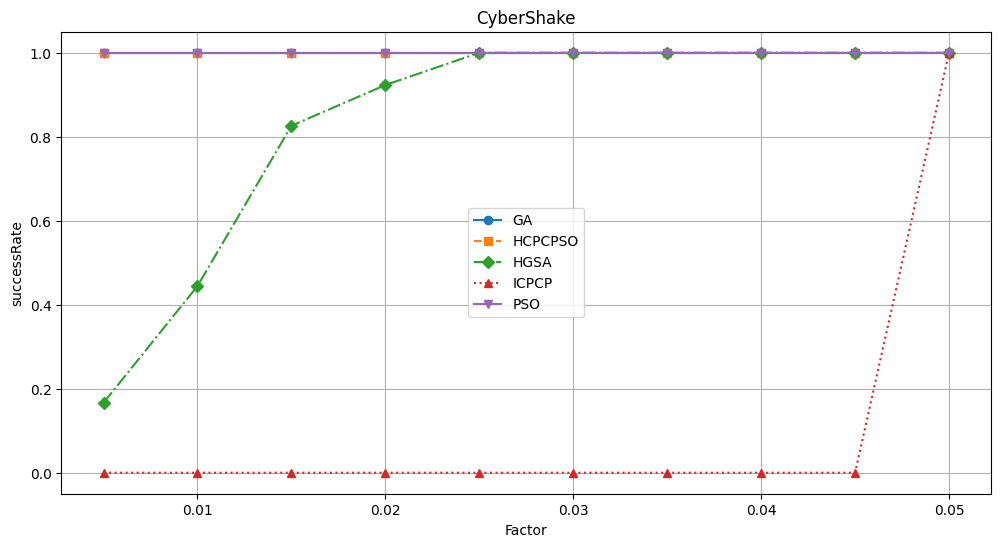

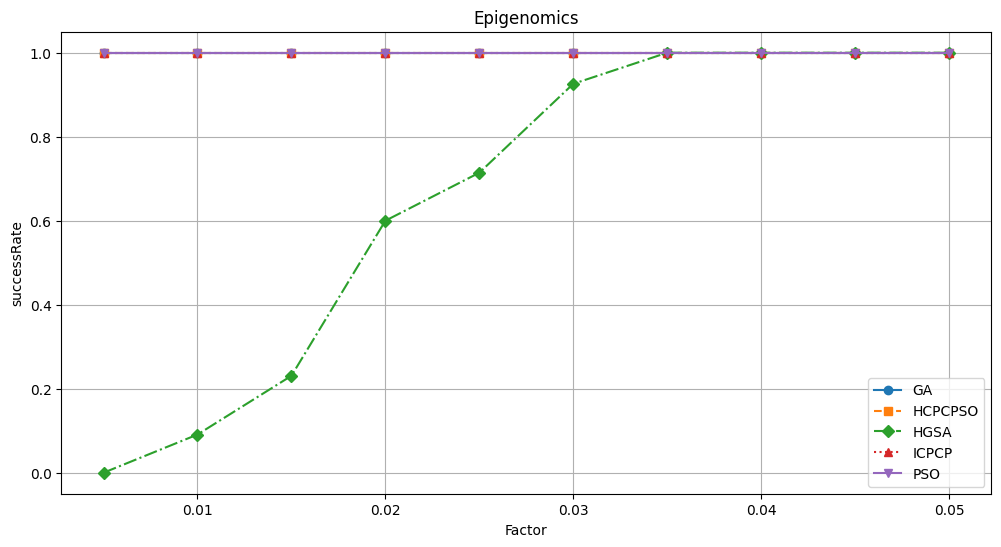

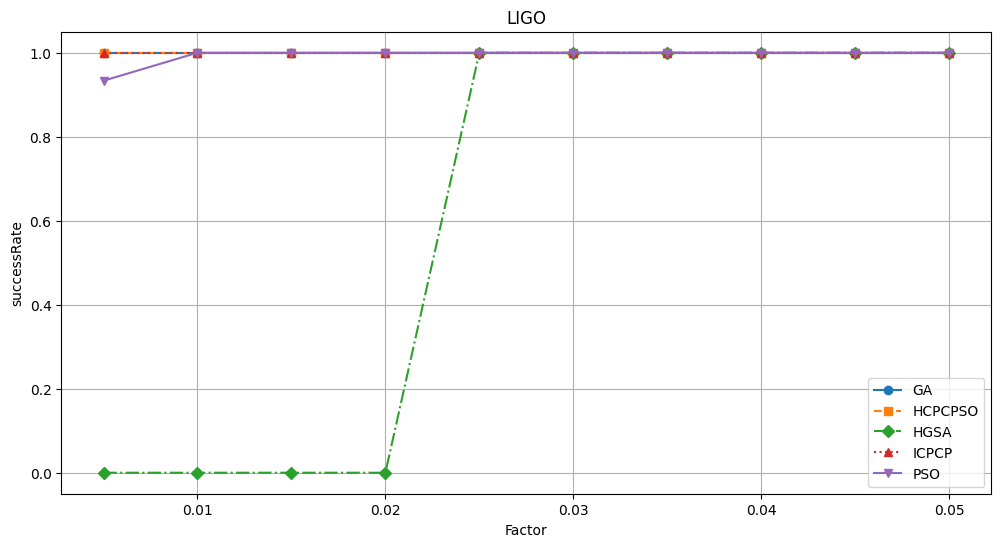

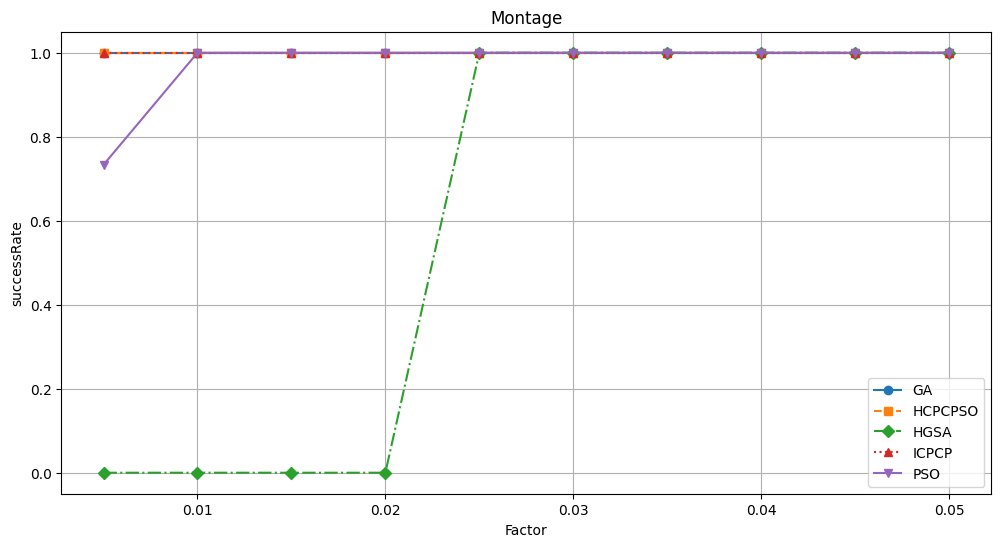

In [15]:
import matplotlib.pyplot as plt
def draw(average_cost, name, typee):
    x_values = [0.005 + 0.005 * i for i in range(10)]
    
    # Tạo biểu đồ
    plt.figure(figsize=(12, 6))
    
    # Các màu sắc, kiểu đường và kiểu điểm đánh dấu khác nhau
    colors = plt.get_cmap('tab10')
    linestyles = ['-', '--', '-.', ':']
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']
    
    for i, (label, series) in enumerate(average_cost.items()):
        # Loại bỏ các giá trị NaN
        clean_series = series.dropna()
        clean_x_values = [x_values[j] for j in clean_series.index]
        
        color = colors(i % 10)
        linestyle = linestyles[i % len(linestyles)]
        marker = markers[i % len(markers)]
        
        plt.plot(clean_x_values, clean_series, marker=marker, linestyle=linestyle, label=label, color=color)
    
    # Thêm nhãn và tiêu đề
    plt.xlabel('Factor')
    plt.ylabel(typee)
    plt.title(name)
    plt.legend()
    plt.grid(True)
    
    # Lưu và hiển thị biểu đồ
    output_path = f'{typee}-{name}.png'
    plt.savefig(output_path)
    plt.show()

listName = ["GA", "HCPCPSO", "HGSA", "ICPCP", "PSO"]
listType = ["CyberShake", "Epigenomics", "LIGO", "Montage"]

'''for i in range(len(listType)):
    typp = listType[i]
    average_cost = {}
    for j in range(len(listName)):
        name = listName[j]
        print(name)
        average_cost[name] = df[name].loc[df[name]['name'] == typp, 'AverageCost'].reset_index(drop=True)
    draw(average_cost, typp, 'Nomarlized Cost')'''

for i in range(len(listType)):
    typp = listType[i]
    sr = {}
    for j in range(len(listName)):
        name = listName[j]
        sr[name] = df[name].loc[df[name]['name'] == typp, 'successRate'].reset_index(drop=True)
    draw(sr, typp, "successRate")


In [27]:
import pandas as pd

# Đọc file Excel
file_path = r"C:\Users\lminh\OneDrive\Desktop\DATN\GA\GeneticAlgorithm\So Sánh\Algorithm\Data\data-GA.xlsx"  # Thay 'path_to_your_file.xlsx' bằng đường dẫn tới file Excel của bạn
df = pd.read_excel(file_path)

# Kiểm tra các cột trong DataFrame
print(df.columns)

# Tính trung bình của cột 'averagecost' ứng với từng 'name'
average_cost_by_name = df.groupby('name')['AverageCost'].mean().reset_index()

output_file_path = 'average_cost_by_name.xlsx'
average_cost_by_name.to_excel(output_file_path, index=False)

print(f"Kết quả đã được ghi vào file {output_file_path}")


Index(['name', 'factor', 'AverageCost', 'AverageRunTime', 'successRate'], dtype='object')
Kết quả đã được ghi vào file average_cost_by_name.xlsx


In [30]:
import pandas as pd

# Đọc file Excel
file_path = "C:/Users/lminh/OneDrive/Desktop/DATN/GA/GeneticAlgorithm/DATA/result-all.xlsx"
df = pd.read_excel(file_path)

# Kiểm tra xem cột runTime và numOfTask có tồn tại không
if 'RunTime' in df.columns and 'numOfTasks' in df.columns:
    # Tính trung bình của cột runTime theo numOfTask
    avg_run_time = df.groupby('numOfTasks')['RunTime'].mean()
    
    # In kết quả
    print(avg_run_time)
else:
    print("Cột 'runTime' hoặc 'numOfTask' không tồn tại trong file Excel.")

numOfTasks
30      20.629682
50      61.648640
100    221.153626
Name: RunTime, dtype: float64
